In [48]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc

In [49]:
# Loading the dataset
# Experiment#1
# data_file = 'training_dataset_per_second.csv'
# test_data_file = 'test-dataset_per_second_70-30.csv'

# Experiment#2
# data_file = 'training_dataset_per_second.csv'
# test_data_file = 'test-dataset_per_second_93-7.csv'

# Experiment#3
# data_file = 'training_dataset_200k.csv'
# test_data_file = 'test-dataset_70-30.csv'

# Experiment#4
data_file = 'training_dataset_200k.csv'
test_data_file = 'test-dataset_93-7.csv'

data = pd.read_csv(data_file)
data_test = pd.read_csv(test_data_file)

In [50]:
# Replace missing values in 'File Extension' column with 'cmd'
data['File Extension'].fillna('cmd', inplace=True)

In [51]:
# Experiment to check and consolidate the data per 5 seconds. Not included for Project Experiments
# Calculate the 'Requests Every 5s' feature
def calculate_requests_every_5s(df):
    # Convert 'Timestamp' to datetime format
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])

    # Sort by 'Client ID' and 'Timestamp'
    df = df.sort_values(by=['Client ID', 'Timestamp'])

    # Initialize the new column with zeros
    df['Requests Every 5s'] = 0

    # Group by 'Client ID'
    grouped = df.groupby('Client ID')

    for name, group in grouped:
        # Calculate the number of requests every 5 seconds for each client
        count_5s = group['Timestamp'].diff().dt.total_seconds().fillna(0).cumsum() // 5
        df.loc[group.index, 'Requests Every 5s'] = group.groupby(count_5s).cumcount() + 1

    return df

# data = calculate_requests_every_5s(data)

# # Save the updated dataset
# data.to_csv('updated_dataset-5050.csv', index=False)

In [52]:
# Experiment to consolidate the data per second. Finalized for Project Experiments
def calculate_requests_and_volume_per_second(df):
    # Convert 'Timestamp' to datetime format
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])

    # Sort by 'Client ID' and 'Timestamp'
    df = df.sort_values(by=['Client ID', 'Timestamp'])

    # Round down the timestamp to the nearest second
    df['Second'] = df['Timestamp'].dt.floor('S')

    # Calculate the number of requests per second for each Client ID
    df['Requests Per Second'] = df.groupby(['Client ID', 'Second'])['Second'].transform('count')

    # Calculate the sum of Data Transfer Volume per second for each Client ID
    df['Volume Per Second'] = df.groupby(['Client ID', 'Second'])['Data Transfer Volume'].transform('sum')

    # Keep only the last record for each second for each Client ID
    df = df.groupby(['Client ID', 'Second']).tail(1)

    # Drop the 'Second' column as it's no longer needed
    df = df.drop(columns=['Second'])

    return df

# data = calculate_requests_and_volume_per_second(data)
# data_test = calculate_requests_and_volume_per_second(data_test)

# Save the updated dataset
# data.to_csv('training_dataset_per_second.csv', index=False)
# data_test.to_csv('test-dataset_per_second_70-30.csv', index=False)

In [53]:
# Experiment to check and consolidate the data per micro seconds. Not included for Project Experiments
def calculate_requests_and_volume_per_microsecond(df):
    # Convert 'Timestamp' to datetime format
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])

    # Sort by 'Client ID' and 'Timestamp'
    df = df.sort_values(by=['Client ID', 'Timestamp'])

    # Round down the timestamp to the nearest microsecond
    df['Microsecond'] = df['Timestamp'].dt.floor('U')

    # Calculate the number of requests per microsecond for each Client ID
    df['Requests Per Microsecond'] = df.groupby(['Client ID', 'Microsecond'])['Microsecond'].transform('count')

    # Calculate the sum of Data Transfer Volume per microsecond for each Client ID
    df['Volume Per Microsecond'] = df.groupby(['Client ID', 'Microsecond'])['Data Transfer Volume'].transform('sum')

    # Keep only the last record for each microsecond for each Client ID
    df = df.groupby(['Client ID', 'Microsecond']).tail(1)

    # Drop the 'Microsecond' column as it's no longer needed
    df = df.drop(columns=['Microsecond'])

    return df

# data = calculate_requests_and_volume_per_microsecond(data)

# # Save the updated dataset
# data.to_csv('reduced_dataset_microsecond-28June.csv', index=False)

In [54]:
# Display the first few rows of the updated dataset
print(data.head())
print(data_test.head())

print(f'Number of rows: {len(data)}')
print(f'Number of test rows: {len(data_test)}')

# Check the distribution of the target variable
print(f"Data Intruder count: {data['Intruder Flag'].value_counts()}")
print(f"Test Data Intruder count: {data_test['Intruder Flag'].value_counts()}")

   Unnamed: 0            Timestamp  Client ID  Message Type  Message Size  \
0     1156271  2024-06-25 14:36:55   client_2             0      12929525   
1     1802394  2024-06-26 13:26:20  intruder2             0            17   
2     1451110  2024-06-26 13:08:50  intruder2             1             1   
3     1967327  2024-07-02 15:17:31   client_1             0      38247618   
4      133960  2024-06-24 11:37:54   client_2             0       9906345   

   Encryption Status File Extension  File Size  Number of Messages  \
0               True            mp4   12929525                   1   
1               True            cmd          0              289312   
2               True            cmd          0                4050   
3               True            mp4   38247618                   1   
4               True            mp4    9906345                   1   

   Number of Files  Client IP  Server Response Time  Connection Duration  \
0                1  10.0.2.16          1

In [55]:
# Feature selection and target variable
features = data[[
    'Client ID',
    'Message Type',
    'Message Size',
    'File Extension',
    'File Size',
    'Connection Duration',
    'Number of Messages',
    'Number of Files',
    'Client IP',
    'Data Transfer Volume',
    'Request Frequency',
    'Error Rate',
    # 'Requests Every 5s',
    # 'Requests Per Second',
    # 'Volume Per Second',
    # 'Requests Per Microsecond',
    # 'Volume Per Microsecond',
]]
target = data['Intruder Flag']

In [56]:
# Feature selection and target variable
features_test = data_test[[
    'Client ID',
    'Message Type',
    'Message Size',
    'File Extension',
    'File Size',
    'Connection Duration',
    'Number of Messages',
    'Number of Files',
    'Client IP',
    'Data Transfer Volume',
    'Request Frequency',
    'Error Rate',
    # 'Requests Every 5s',
    # 'Requests Per Second',
    # 'Volume Per Second',
    # 'Requests Per Microsecond',
    # 'Volume Per Microsecond',
]]
target_test = data_test['Intruder Flag']

In [57]:
# Handling missing values by imputing with mean for numerical features
numeric_features = [
    # 'Message Type',
    'Message Size',
    'File Size',
    'Connection Duration',
    # 'Number of Messages',
    # 'Number of Files',
    'Data Transfer Volume',
    # 'Request Frequency',
    # 'Error Rate',
    # 'Requests Every 5s',
    # 'Requests Per Second',
    # 'Volume Per Second',
    # 'Requests Per Microsecond',
    # 'Volume Per Microsecond',
]

numeric_transformer = SimpleImputer(strategy='mean')

# numeric_transformer = Pipeline(steps=[
#     ('imputer', SimpleImputer(strategy='mean')),
#     ('scaler', StandardScaler())
# ])

In [58]:
# Handling categorical features
categorical_features = [
    # 'Client ID',
    # 'File Extension',
    # 'Client IP'
]

categorical_transformer = OneHotEncoder(handle_unknown='ignore')
# y_train_encoded = categorical_transformer.fit_transform(y_train.reshape(-1, 1))

# categorical_transformer = Pipeline(steps=[
#     ('onehot', OneHotEncoder(handle_unknown='ignore'))
# ])
print(f'Numeric features: {numeric_features} \nCategorical features: {categorical_features if categorical_features else None}')

Numeric features: ['Message Size', 'File Size', 'Connection Duration', 'Data Transfer Volume'] 
Categorical features: None


In [59]:
# Preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

In [60]:
# Splitting the dataset into training and testing sets
X_train, X_val, y_train, y_val = train_test_split(features, target, test_size=0.2, random_state=42)
X_test, y_test = features_test, target_test

In [61]:
# Apply preprocessing to the features
X_train = preprocessor.fit_transform(X_train)
X_val = preprocessor.transform(X_val)
X_test = preprocessor.transform(X_test)

# Convert target to categorical
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)

In [62]:
# print(f'X_train_scale shape: {X_train_scale.shape}')
# print(f'X_val_scale shape: {X_val_scale.shape}')
# print(f'X_test_scale shape: {X_test_scale.shape}')
# print(f'y_train shape: {y_train.shape}')
# print(f'y_val shape: {y_val.shape}')
# print(f'y_test shape: {y_test.shape}')

In [63]:
from sklearn.preprocessing import MinMaxScaler

# Initialize the scaler
scaler = MinMaxScaler()

# Fit the scaler on the training data
X_train_scale = scaler.fit_transform(X_train)
X_val_scale = scaler.transform(X_val)
X_test_scale = scaler.transform(X_test)

print(X_train_scale)

[[1.11522768e-02 1.11522768e-02 9.86304391e-01 8.68831030e-01]
 [1.01314569e-02 1.01314569e-02 1.81253726e-01 6.23383662e-01]
 [3.56208701e-02 3.56208701e-02 1.23098442e-02 7.36753641e-02]
 ...
 [4.16201502e-02 4.16201502e-02 1.33045061e-02 3.88372560e-01]
 [1.58324838e-08 0.00000000e+00 5.38991120e-03 4.99094774e-03]
 [9.18264873e-03 9.18264873e-03 1.00660654e-01 4.27784809e-01]]


In [64]:
print(f'X_train_scale shape: {X_train_scale.shape}')
print(f'X_val_scale shape: {X_val_scale.shape}')
print(f'X_test_scale shape: {X_test_scale.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'y_val shape: {y_val.shape}')
print(f'y_test shape: {y_test.shape}')

X_train_scale shape: (158827, 4)
X_val_scale shape: (39707, 4)
X_test_scale shape: (48160, 4)
y_train shape: (158827, 2)
y_val shape: (39707, 2)
y_test shape: (48160, 2)


In [65]:
# from sklearn.preprocessing import StandardScaler

# # Initialize the scaler
# scaler = StandardScaler(with_mean=False)

# # Fit the scaler on the training data
# X_train_scale = scaler.fit_transform(X_train)
# X_test_scale = scaler.transform(X_test)

# print(X_train_scale)

In [66]:
# Build the neural network model
model = Sequential()
model.add(Dense(64, input_dim=X_train_scale.shape[1], activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))  # Binary Classification

In [67]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam

optimizer = Adam(learning_rate=0.0015)

# Compile the model
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
# model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [68]:
# Early stopping callback
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=0, restore_best_weights=True)

# Train the model
# Convert sparse matrices to dense NumPy arrays
# X_train_dense = X_train_scale.toarray()

history = model.fit(
                    # X_train_dense,
                    X_train_scale,
                    y_train,
                    epochs=50,
                    batch_size=32,
                    # validation_split=0.2,
                    validation_data=(X_val_scale, y_val),
                    callbacks=[early_stopping])

Epoch 1/50
4964/4964 [==============================] - 11s 2ms/step - loss: 0.1164 - accuracy: 0.9577 - val_loss: 0.0228 - val_accuracy: 0.9934
Epoch 2/50
4964/4964 [==============================] - 9s 2ms/step - loss: 0.0298 - accuracy: 0.9920 - val_loss: 0.0162 - val_accuracy: 0.9978
Epoch 3/50
4964/4964 [==============================] - 10s 2ms/step - loss: 0.0231 - accuracy: 0.9937 - val_loss: 0.0090 - val_accuracy: 0.9968
Epoch 4/50
4964/4964 [==============================] - 10s 2ms/step - loss: 0.0205 - accuracy: 0.9945 - val_loss: 0.0087 - val_accuracy: 0.9981
Epoch 5/50
4964/4964 [==============================] - 10s 2ms/step - loss: 0.0233 - accuracy: 0.9941 - val_loss: 0.0238 - val_accuracy: 0.9898


In [69]:
# Evaluate the model
val_loss, val_accuracy = model.evaluate(X_val_scale, y_val)
print(f'Validation Loss: {val_loss}')
print(f'Validation Accuracy: {val_accuracy}')

1241/1241 [==============================] - 2s 1ms/step - loss: 0.0087 - accuracy: 0.9981
Validation Loss: 0.008727658540010452
Validation Accuracy: 0.9980859756469727


In [70]:
# Get the best model weights from the early stopping callback
best_model_weights = early_stopping.best_weights

# Extract the best model weights from the training history

def score_model_with_permuted_features(X, y):
    """
    This function resets the model's weights to their best state (from early stopping),
    permutes the features one by one, and evaluates the model's performance on the permuted data.
    """
    model.set_weights(best_model_weights)

    X_permuted = X.copy()
    for col in X_permuted.columns:
        X_permuted[col] = np.random.permutation(X_permuted[col])

    # Assuming you want to use 'accuracy' as the metric
    loss, accuracy = model.evaluate(X_permuted, y, verbose=0)
    return accuracy  # Return the desired metric

In [71]:
# Create a custom estimator class for your model
from sklearn.base import BaseEstimator
class KerasModelWrapper(BaseEstimator):
    def __init__(self, model, best_weights):
        self.model = model
        self.best_weights = best_weights

    def fit(self, X, y):
        # No fitting needed since we already have the best weights
        return self

    def score(self, X, y):
        # Same scoring logic as your function
        self.model.set_weights(self.best_weights)
        return score_model_with_permuted_features(X, y)

# Create an instance of the wrapper class
estimator = KerasModelWrapper(model, best_model_weights)

In [72]:
print(f'X_train_scale shape: {X_train_scale.shape}')
print(f'X_val_scale shape: {X_val_scale.shape}')
print(f'X_test_scale shape: {X_test_scale.shape}')

X_train_scale shape: (158827, 4)
X_val_scale shape: (39707, 4)
X_test_scale shape: (48160, 4)


In [73]:
# Get permutation importance
from sklearn.inspection import permutation_importance
# y_train_encoded = y_train_encoded[:X_train_scale.shape[0]]  # Adjust slicing as needed

# Convert X_val_scale to a DataFrame if it's not already
if not isinstance(X_val_scale, pd.DataFrame):
    X_val_scale = pd.DataFrame(X_val_scale, columns=[f"feature_{i}" for i in range(X_val_scale.shape[1])])

# Perform permutation importance
result = permutation_importance(
    estimator,
    X_val_scale,   # Use validation data to avoid overfitting bias
    y_val,
    n_repeats=10,  # Number of times to repeat the permutation
    random_state=42
    # scoring='accuracy'   # Removed since it's already handled in score_model_with_permuted_features
)

# **Get feature names from X_val_scale instead of 'features'**
feature_names = X_val_scale.columns

# Create the DataFrame to map feature names to importances
feature_names = features.columns  # Assuming 'features' is a DataFrame
# importances_df = pd.DataFrame({
#     'Feature': feature_names,
#     'Importance Mean': result.importances_mean,
#     'Importance Std': result.importances_std
# })

# print(importances_df)

In [74]:
# Make predictions
y_pred = np.argmax(model.predict(X_val_scale), axis=-1)
y_val_true = np.argmax(y_val, axis=-1)

1241/1241 [==============================] - 1s 1ms/step


In [75]:
# Make predictions
y_pred = np.argmax(model.predict(X_val), axis=-1)
y_val_true = np.argmax(y_val, axis=-1)

1241/1241 [==============================] - 2s 1ms/step


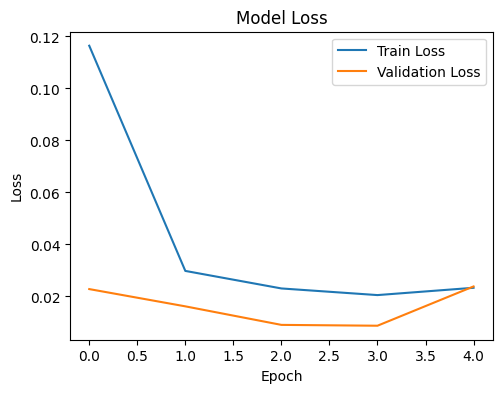

In [76]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

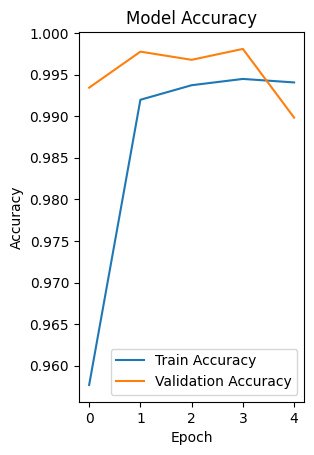

In [77]:
# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

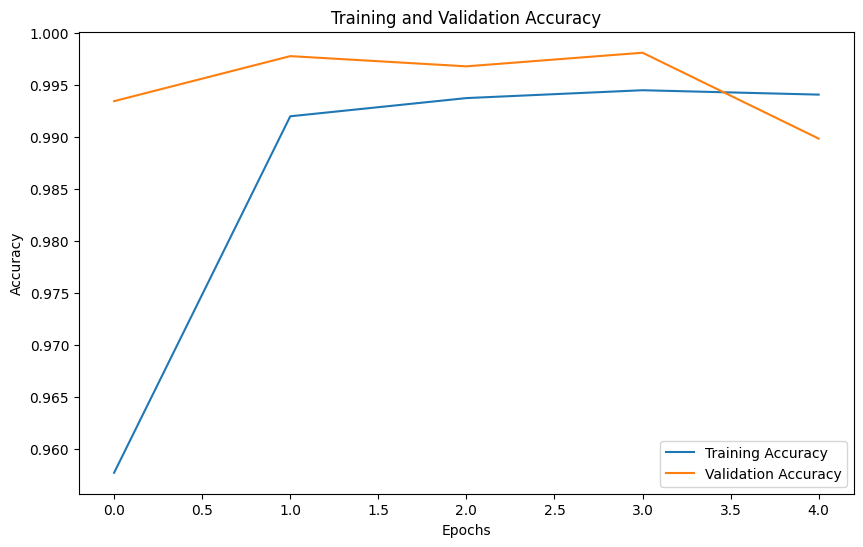

In [78]:
# Plotting cross-validation scores (using validation accuracy)
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

1241/1241 [==============================] - 1s 1ms/step


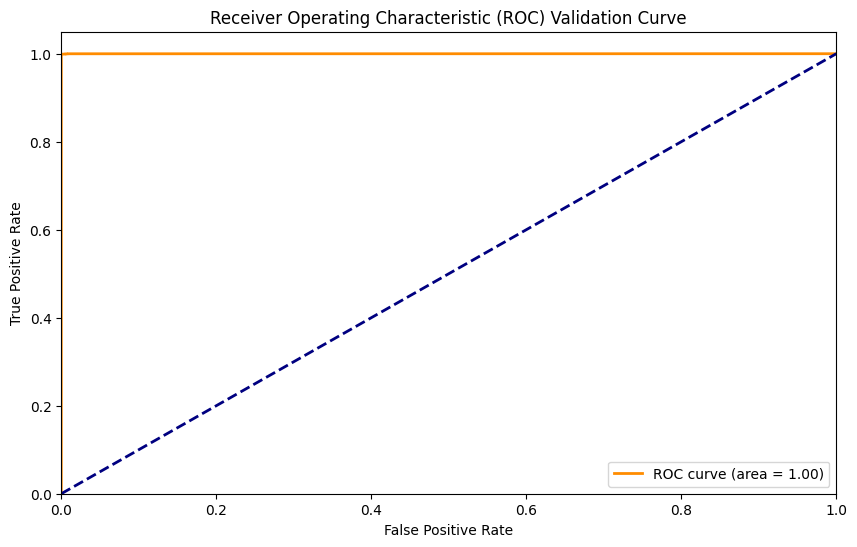

In [79]:
# ROC Curve and AUC for validation data
y_proba = model.predict(X_val_scale)[:, 1]
fpr, tpr, thresholds = roc_curve(y_val_true, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Validation Curve')
plt.legend(loc='lower right')
plt.show()

In [80]:
print(X_test_scale)
print(X_test)
print(y_test)

[[4.20135446e-03 4.20135446e-03 7.52809233e-04 1.72120184e-02]
 [1.47069693e-02 1.47069693e-02 1.82922933e-03 5.61021610e-02]
 [1.47039453e-02 1.47039453e-02 3.65101851e-04 3.07184353e-02]
 ...
 [1.47069693e-02 1.47069693e-02 1.59708170e-03 3.47197916e-02]
 [1.47039453e-02 1.47039453e-02 1.23365797e-05 4.62665234e-03]
 [1.33060012e-03 1.33060012e-03 1.74264583e-04 9.62972623e-04]]
[[4.51117000e+06 4.51117000e+06 1.37009657e+02 8.85856100e+06]
 [1.57914880e+07 1.57914880e+07 3.32913272e+02 2.88742670e+07]
 [1.57882410e+07 1.57882410e+07 6.64486580e+01 1.58099490e+07]
 ...
 [1.57914880e+07 1.57914880e+07 2.90663447e+02 1.78693390e+07]
 [1.57882410e+07 1.57882410e+07 2.24696600e+00 2.38121300e+06]
 [1.42872100e+06 1.42872100e+06 3.17171340e+01 4.95616000e+05]]
[[1. 0.]
 [1. 0.]
 [0. 1.]
 ...
 [1. 0.]
 [0. 1.]
 [1. 0.]]


In [81]:
print(f'X_test_scale shape: {X_test_scale.shape}')
print(f'y_test shape: {y_test.shape}')

X_test_scale shape: (48160, 4)
y_test shape: (48160, 2)


In [82]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test_scale, y_test)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

# Make predictions on the test set
y_pred_test = np.argmax(model.predict(X_test_scale), axis=-1)
y_test_true = np.argmax(y_test, axis=-1)

1505/1505 [==============================] - 2s 1ms/step - loss: 0.1992 - accuracy: 0.9387
Test Loss: 0.19920289516448975
Test Accuracy: 0.9386627674102783
1505/1505 [==============================] - 2s 1ms/step


In [83]:
# Evaluate the model on the test set
print("Test Confusion Matrix:")
cm = confusion_matrix(y_test_true, y_pred_test)
print(cm)

print("\nTest Classification Report:")
print(classification_report(y_test_true, y_pred_test))

print("\nTest Accuracy Score:")
print(accuracy_score(y_test_true, y_pred_test))

Test Confusion Matrix:
[[43443  1433]
 [ 1521  1763]]

Test Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97     44876
           1       0.55      0.54      0.54      3284

    accuracy                           0.94     48160
   macro avg       0.76      0.75      0.76     48160
weighted avg       0.94      0.94      0.94     48160


Test Accuracy Score:
0.9386627906976744


1505/1505 [==============================] - 2s 1ms/step


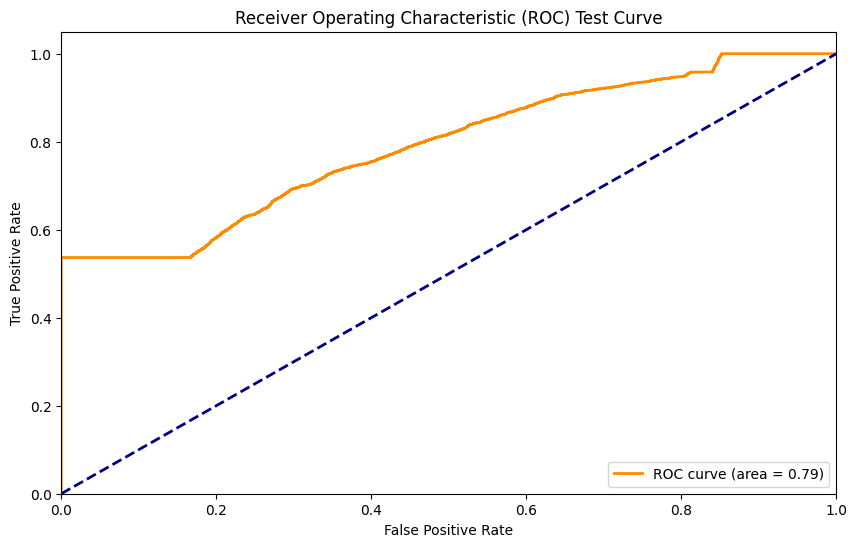

In [84]:
# ROC Curve and AUC for test data
y_proba_test = model.predict(X_test_scale)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test_true, y_proba_test)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Test Curve')
plt.legend(loc='lower right')
plt.show()

In [85]:
# Inference: Display Ground Truth and Predicted values
results = pd.DataFrame({
    'Client ID': data_test['Client ID'],
    'Ground Truth': np.argmax(y_test, axis=1), # Convert y_test to 1D by getting the index of the max value in each row
    'Predicted': y_pred_test
})

print("\nInference Results:")
print(results)

# Display detected intruders
detected_intruders = results[results['Predicted'] == 1]
detected_clients = results[results['Predicted'] == 0]
print("\nDetected Intruders:")
print(detected_intruders)

# Matrix for correctly and incorrectly detected intruders and clients
tn, fp, fn, tp = cm.ravel()
matrix = pd.DataFrame({
    'Correctly Detected': [tn, tp],
    'Incorrectly Detected': [fp, fn]
}, index=['Clients', 'Intruders'])

print("\nDetection Matrix:")
print(matrix)


Inference Results:
       Client ID  Ground Truth  Predicted
0       client_5             0          0
1       client_1             0          0
2      intruder2             1          0
3       client_1             0          0
4       client_1             0          0
...          ...           ...        ...
48155   client_1             0          0
48156   client_1             0          0
48157   client_1             0          0
48158  intruder2             1          0
48159   client_5             0          0

[48160 rows x 3 columns]

Detected Intruders:
       Client ID  Ground Truth  Predicted
6      intruder2             1          1
8       client_1             0          1
9      intruder2             1          1
17      client_1             0          1
20     intruder2             1          1
...          ...           ...        ...
48088  intruder2             1          1
48101  intruder2             1          1
48109  intruder2             1          1
48127  in

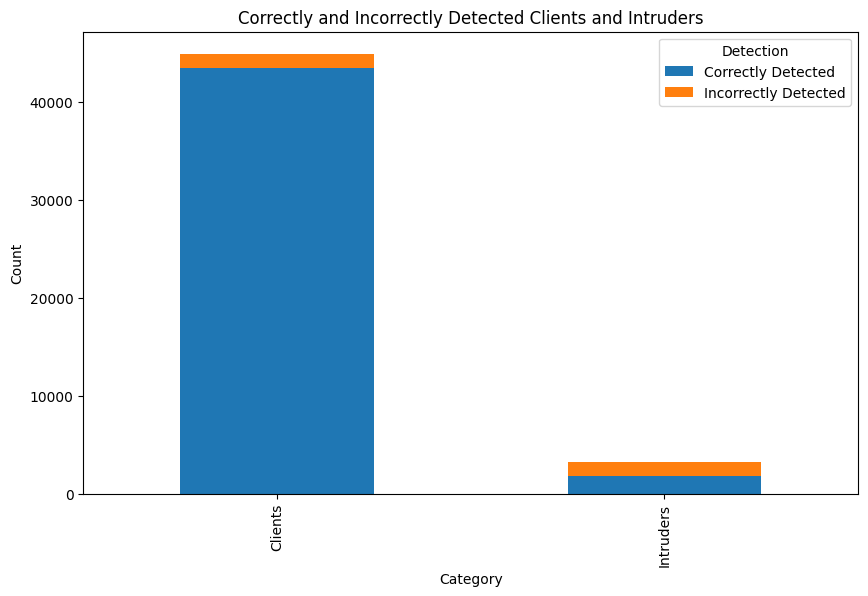

In [86]:
# Plot the matrix
matrix.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Correctly and Incorrectly Detected Clients and Intruders')
plt.xlabel('Category')
plt.ylabel('Count')
plt.legend(title='Detection')
plt.show()

In [87]:
# Calculate confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test_true, y_pred_test).ravel()

# Calculate evaluation metrics
accuracy = (tp + tn) / (tp + tn + fp + fn)
recall = tp / (tp + fn)
precision = tp / (tp + fp)
fpr = fp / (fp + tn)

In [88]:
print(f'Client Detection Success Rate (TNR) for test dataset: {(tn / (tn + fp) * 100):.2f}%')
print(f'Intruder Detection Success Rate (TPR) for test dataset: {(tp / (tp + fn) * 100):.2f}%')

Client Detection Success Rate (TNR) for test dataset: 96.81%
Intruder Detection Success Rate (TPR) for test dataset: 53.68%


In [89]:
# Calculate DR, FPR, and FNR for different thresholds
y_proba = model.predict(X_test_scale)[:, 1]
fpr_list, recall_list, threshold_list = roc_curve(y_test_true, y_proba)

dr_list = recall_list
fnr_list = 1 - recall_list

1505/1505 [==============================] - 2s 1ms/step


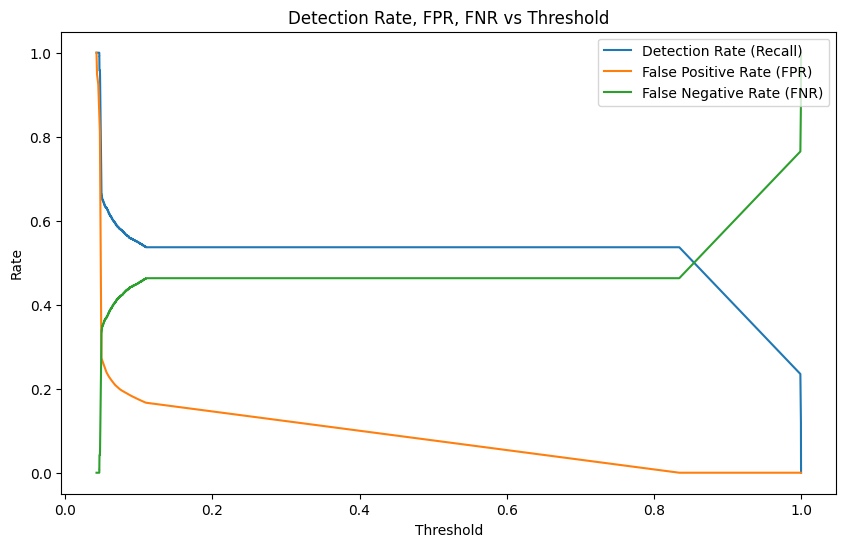

In [90]:
plt.figure(figsize=(10, 6))
plt.plot(threshold_list, dr_list, label='Detection Rate (Recall)')
plt.plot(threshold_list, fpr_list, label='False Positive Rate (FPR)')
plt.plot(threshold_list, fnr_list, label='False Negative Rate (FNR)')
plt.xlabel('Threshold')
plt.ylabel('Rate')
plt.title('Detection Rate, FPR, FNR vs Threshold')
plt.legend(loc='upper right')
plt.show()